# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Idea" data-toc-modified-id="Idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Idea</a></div><div class="lev1 toc-item"><a href="#Simulate-data" data-toc-modified-id="Simulate-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate data</a></div><div class="lev1 toc-item"><a href="#Is-this-kernel-stationary?" data-toc-modified-id="Is-this-kernel-stationary?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Is this kernel stationary?</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\scrl}{\mathscr{l}}
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\trans}{^{\intercal}}
$$

# Idea

In our last meeting, Luke B mentioned that the parameters in the linear regression component of my NYC model could themselves be spatially varying. I had never thought that that would be easy to implement, but if I understood Luke B's explanation correctly, I think the idea is simply to introduce a product kernel of a linear kernel and a squared exponential kernel.

The squared exponential kernel on the spatial covariates $x$ is:
$$ k(x, x') = \sigma_f^2 \exp\del{ - (x-x')^2 / (2\scrl^2)} $$
And the linear (dot) kernel on the additional covariates $d$ is:
$$ k(d, d') = \sigma_\beta^2 d \cdot d' $$
So the product kernel reduces to:
$$ k(x, x', d, d') = \sigma_f^2 \exp\del{ - (x-x')^2 / (2\scrl^2)} \sbr{d \cdot d'} $$

This can be understood as a spatially varying random slope model.

In our meeting, we decided that while that was a good idea, it would complicate things a lot for the NYC example, muddling up the basic analysis we're trying to demonstrate. 

However, the similarity between this kernel and local linear regression struck me. I wondered how this kernel would behave if we used it directly for the spatial covariate:

$$ k(x, x') = \sigma_f^2 \exp\del{ - (x-x')^2 / (2\scrl^2)} \sbr{x \cdot x'} $$

In particular, could we recover the extrapolating behavior of local linear regression, with ever-widening standard errors as we move further away from the data? This would contrast with the squared exponential kernel where the standard errors converge to the prior. We saw in the NYC example that the SE behavior is problematic, as our modeled claimed to detect very significant treatment effects across boundaries that only saw sales on one side. That's troubling from the standpoint of RDD theory.

In [1]:
using GaussianProcesses
using GaussianProcesses: cov
using Distributions
import PyPlot; plt=PyPlot
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Simulate data

In [3]:
thresh = 0.0

# data-generating parameters
_σf_star = 1.0
_Lstar  = 1.05
_τstar = 0.7
_σy_star = 0.3

_στ2 = 100.0 # diffuse normal prior on τ
se = SEIso(log(_Lstar), log(√_σf_star))
n_xx = 1000
n_obs = 200
xx = collect(linspace(-10.0,10.0,n_xx))
_X = randn(n_obs)*2.0
# create a gap
_X[_X.>0.0] .+= 0.5
_X[_X.<0.0] .-= 0.5
gp_star = GP(;m=MeanZero(), k=se, logNoise=1e-8)

_f = rand(gp_star, vcat(xx, _X)')
_f_xx = _f[1:n_xx]
_f_obs = _f[n_xx+1:end]

noise = rand(Normal(0,_σy_star), n_obs)
_Y = _f_obs .+ noise .+ _τstar * (_X.>thresh)
;

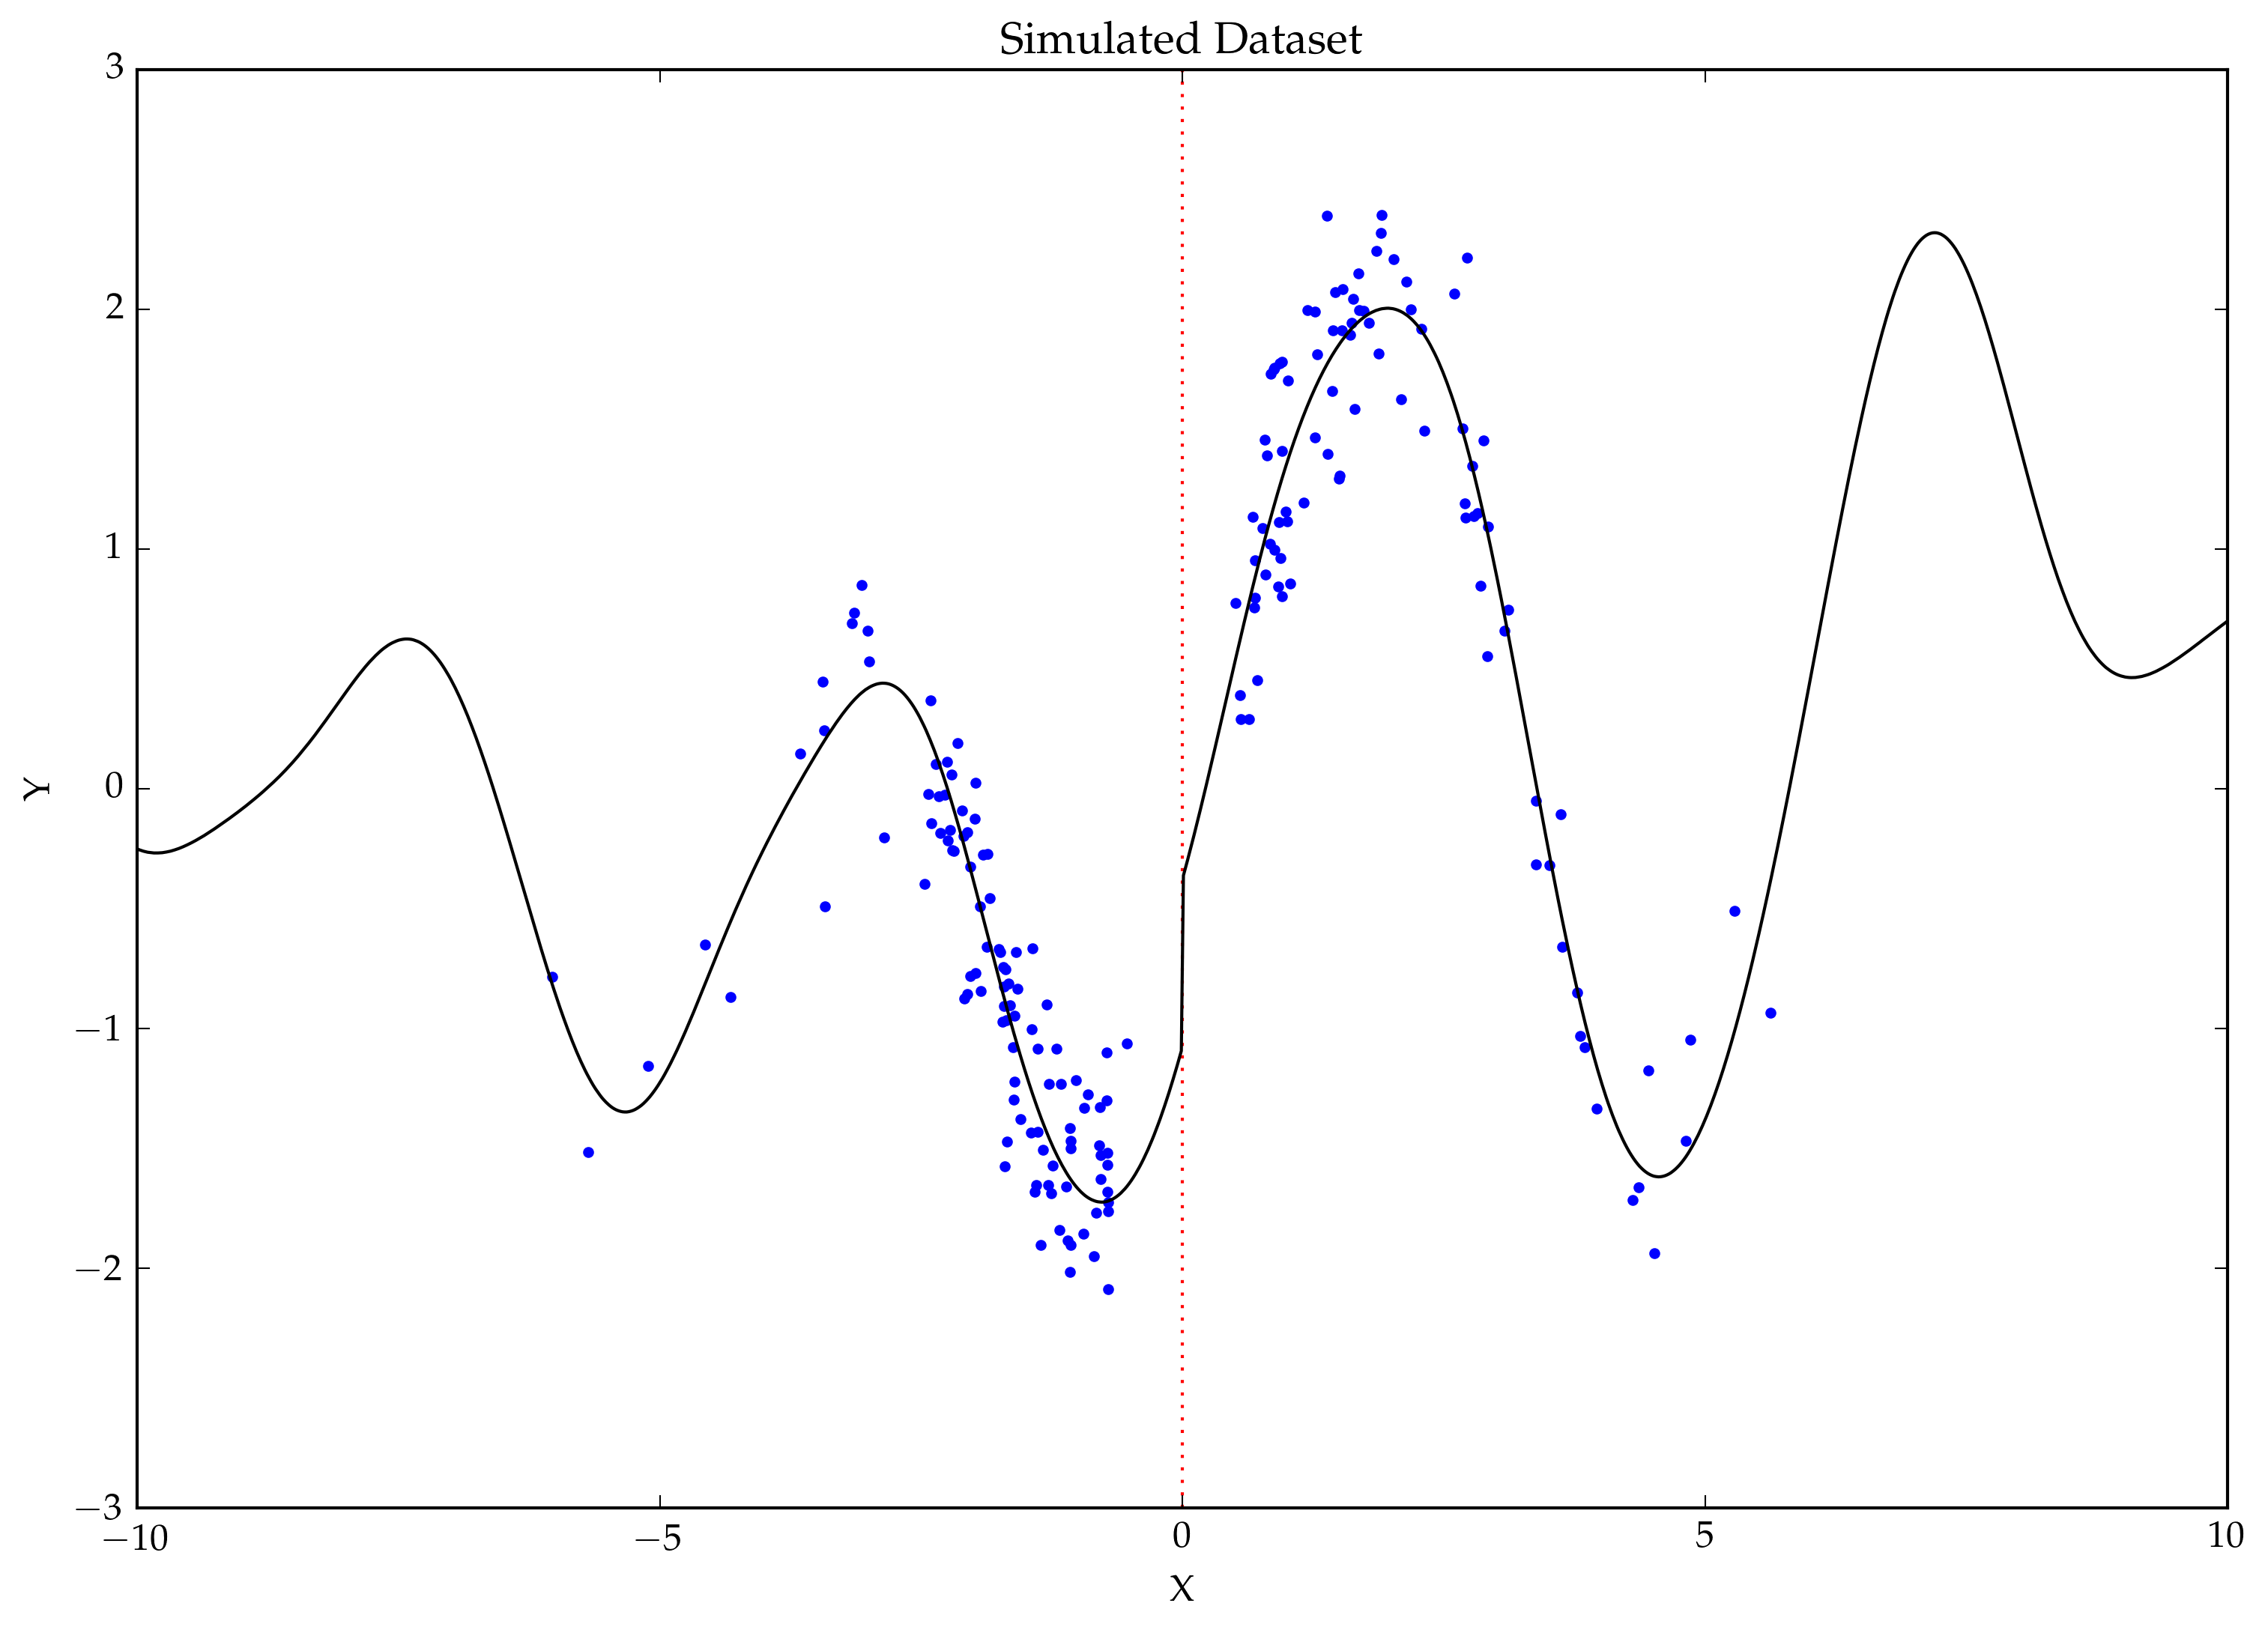

In [4]:
plt.svg(false)
plt.plot(_X, _Y, ".")
plt.axvline(x=0.0, color="red", linestyle=":")
plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

In [5]:
k_spatialslope = LinIso(0.0) * se + se

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.LinIso, Params: [0.0]
    Type: GaussianProcesses.SEIso, Params: [0.0487902,0.0]
  Type: GaussianProcesses.SEIso, Params: [0.0487902,0.0]


In [6]:
left = _X .< 0.0

lin_fit_left  = GP(_X[left]',  _Y[left],  MeanZero(), k_spatialslope, log(_σy_star))
lin_fit_right = GP(_X[!left]', _Y[!left], MeanZero(), k_spatialslope, log(_σy_star))

se_fit_left  = GP(_X[left]',  _Y[left],  MeanZero(), se, log(_σy_star))
se_fit_right = GP(_X[!left]', _Y[!left], MeanZero(), se, log(_σy_star))
;

In [20]:
function plot_fit(xx, fit_left::GP, fit_right::GP)
    xx_left = xx .< 0.0
    xx_right = xx .> 0.0
    
    μ_left, Σ_left = predict(fit_left, xx[xx_left]')
    fit_color = "#009F77"
    plt.plot( xx[xx_left], μ_left, color=fit_color, label="fitted")
    lower = μ_left-2.0*√Σ_left
    upper = μ_left+2.0*√Σ_left
    plt.fill_between(xx[xx_left], lower, upper, color=fit_color, alpha=0.3)

    μ_right, Σ_right = predict(fit_right, xx[xx_right]')
    fit_color = "#009F77"
    plt.plot( xx[xx_right], μ_right, color=fit_color)
    lower = μ_right-2.0*√Σ_right
    upper = μ_right+2.0*√Σ_right
    plt.fill_between(xx[xx_right], lower, upper, color=fit_color, alpha=0.3)
    
    plt.plot(xx, _f_xx+_τstar*(xx.>thresh), color="black", label="truth")

    plt.plot(_X, _Y, ".", color="black")
    plt.axvline(x=0.0, color="red", linestyle=":")
    plt.legend(loc="bottom left")
end

plot_fit (generic function with 1 method)

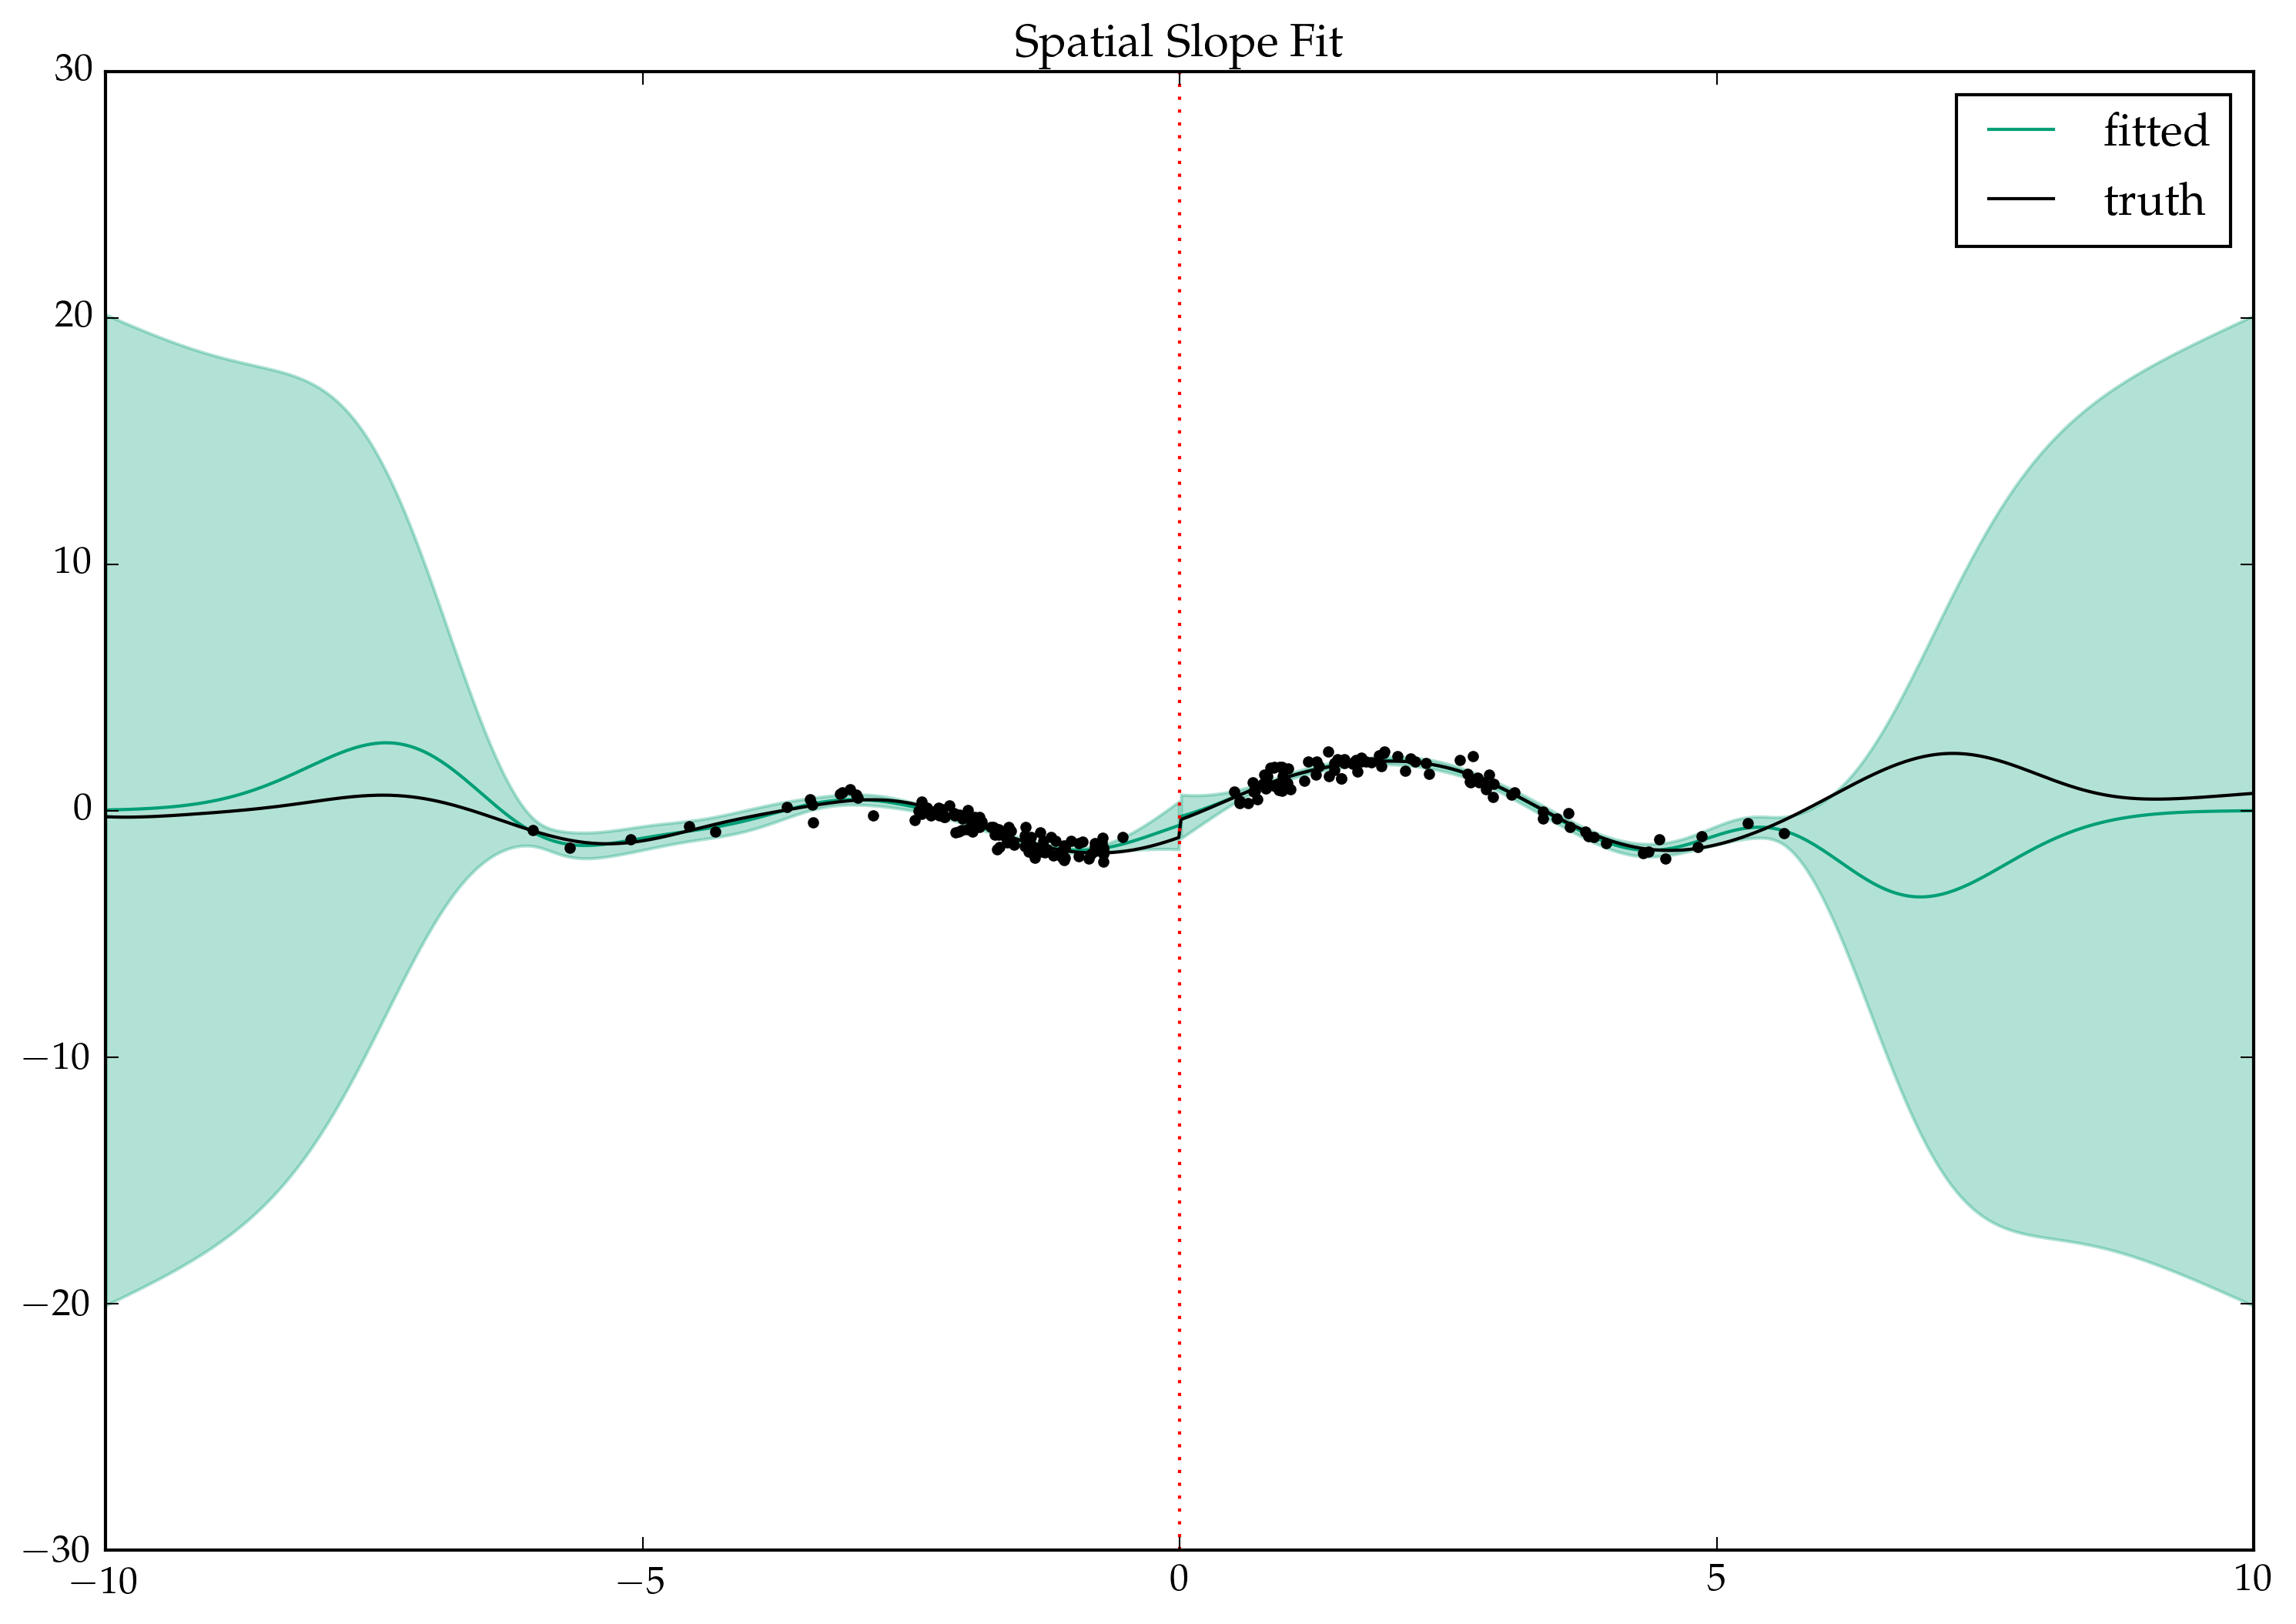

In [21]:
plot_fit(xx, lin_fit_left, lin_fit_right)
plt.title("Spatial Slope Fit")
;

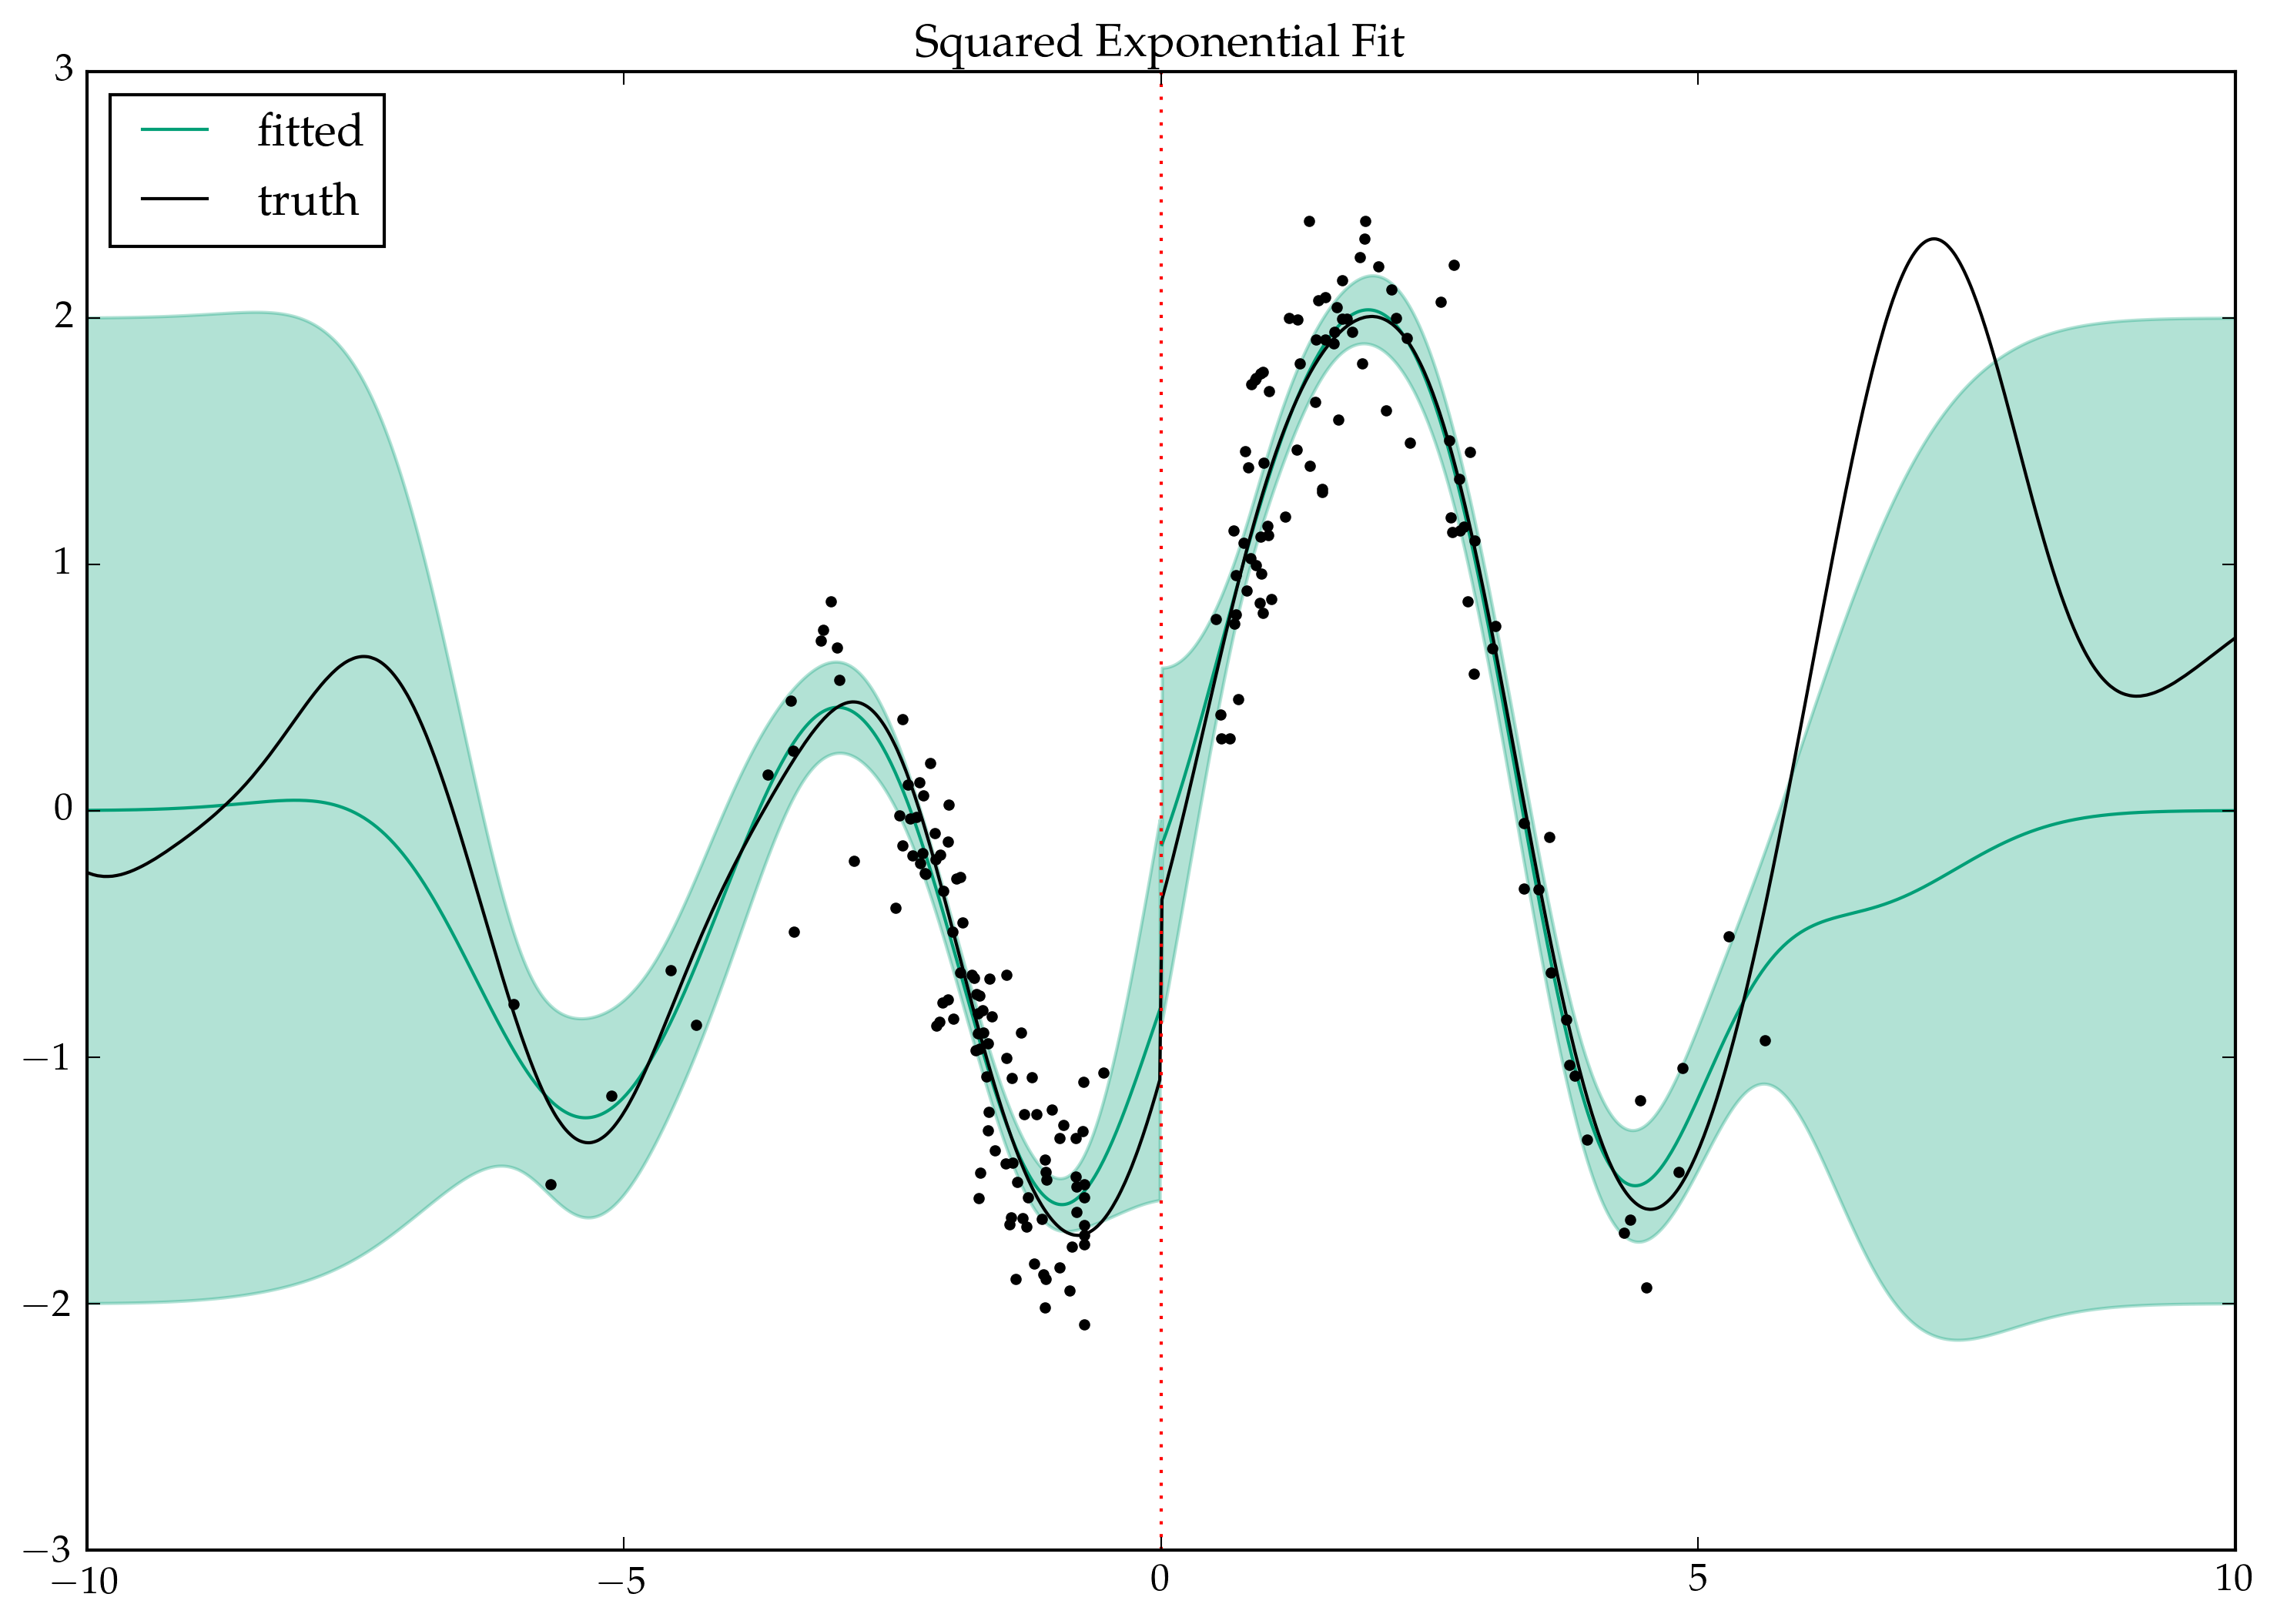

In [22]:
plot_fit(xx, se_fit_left, se_fit_right)
plt.title("Squared Exponential Fit")
;

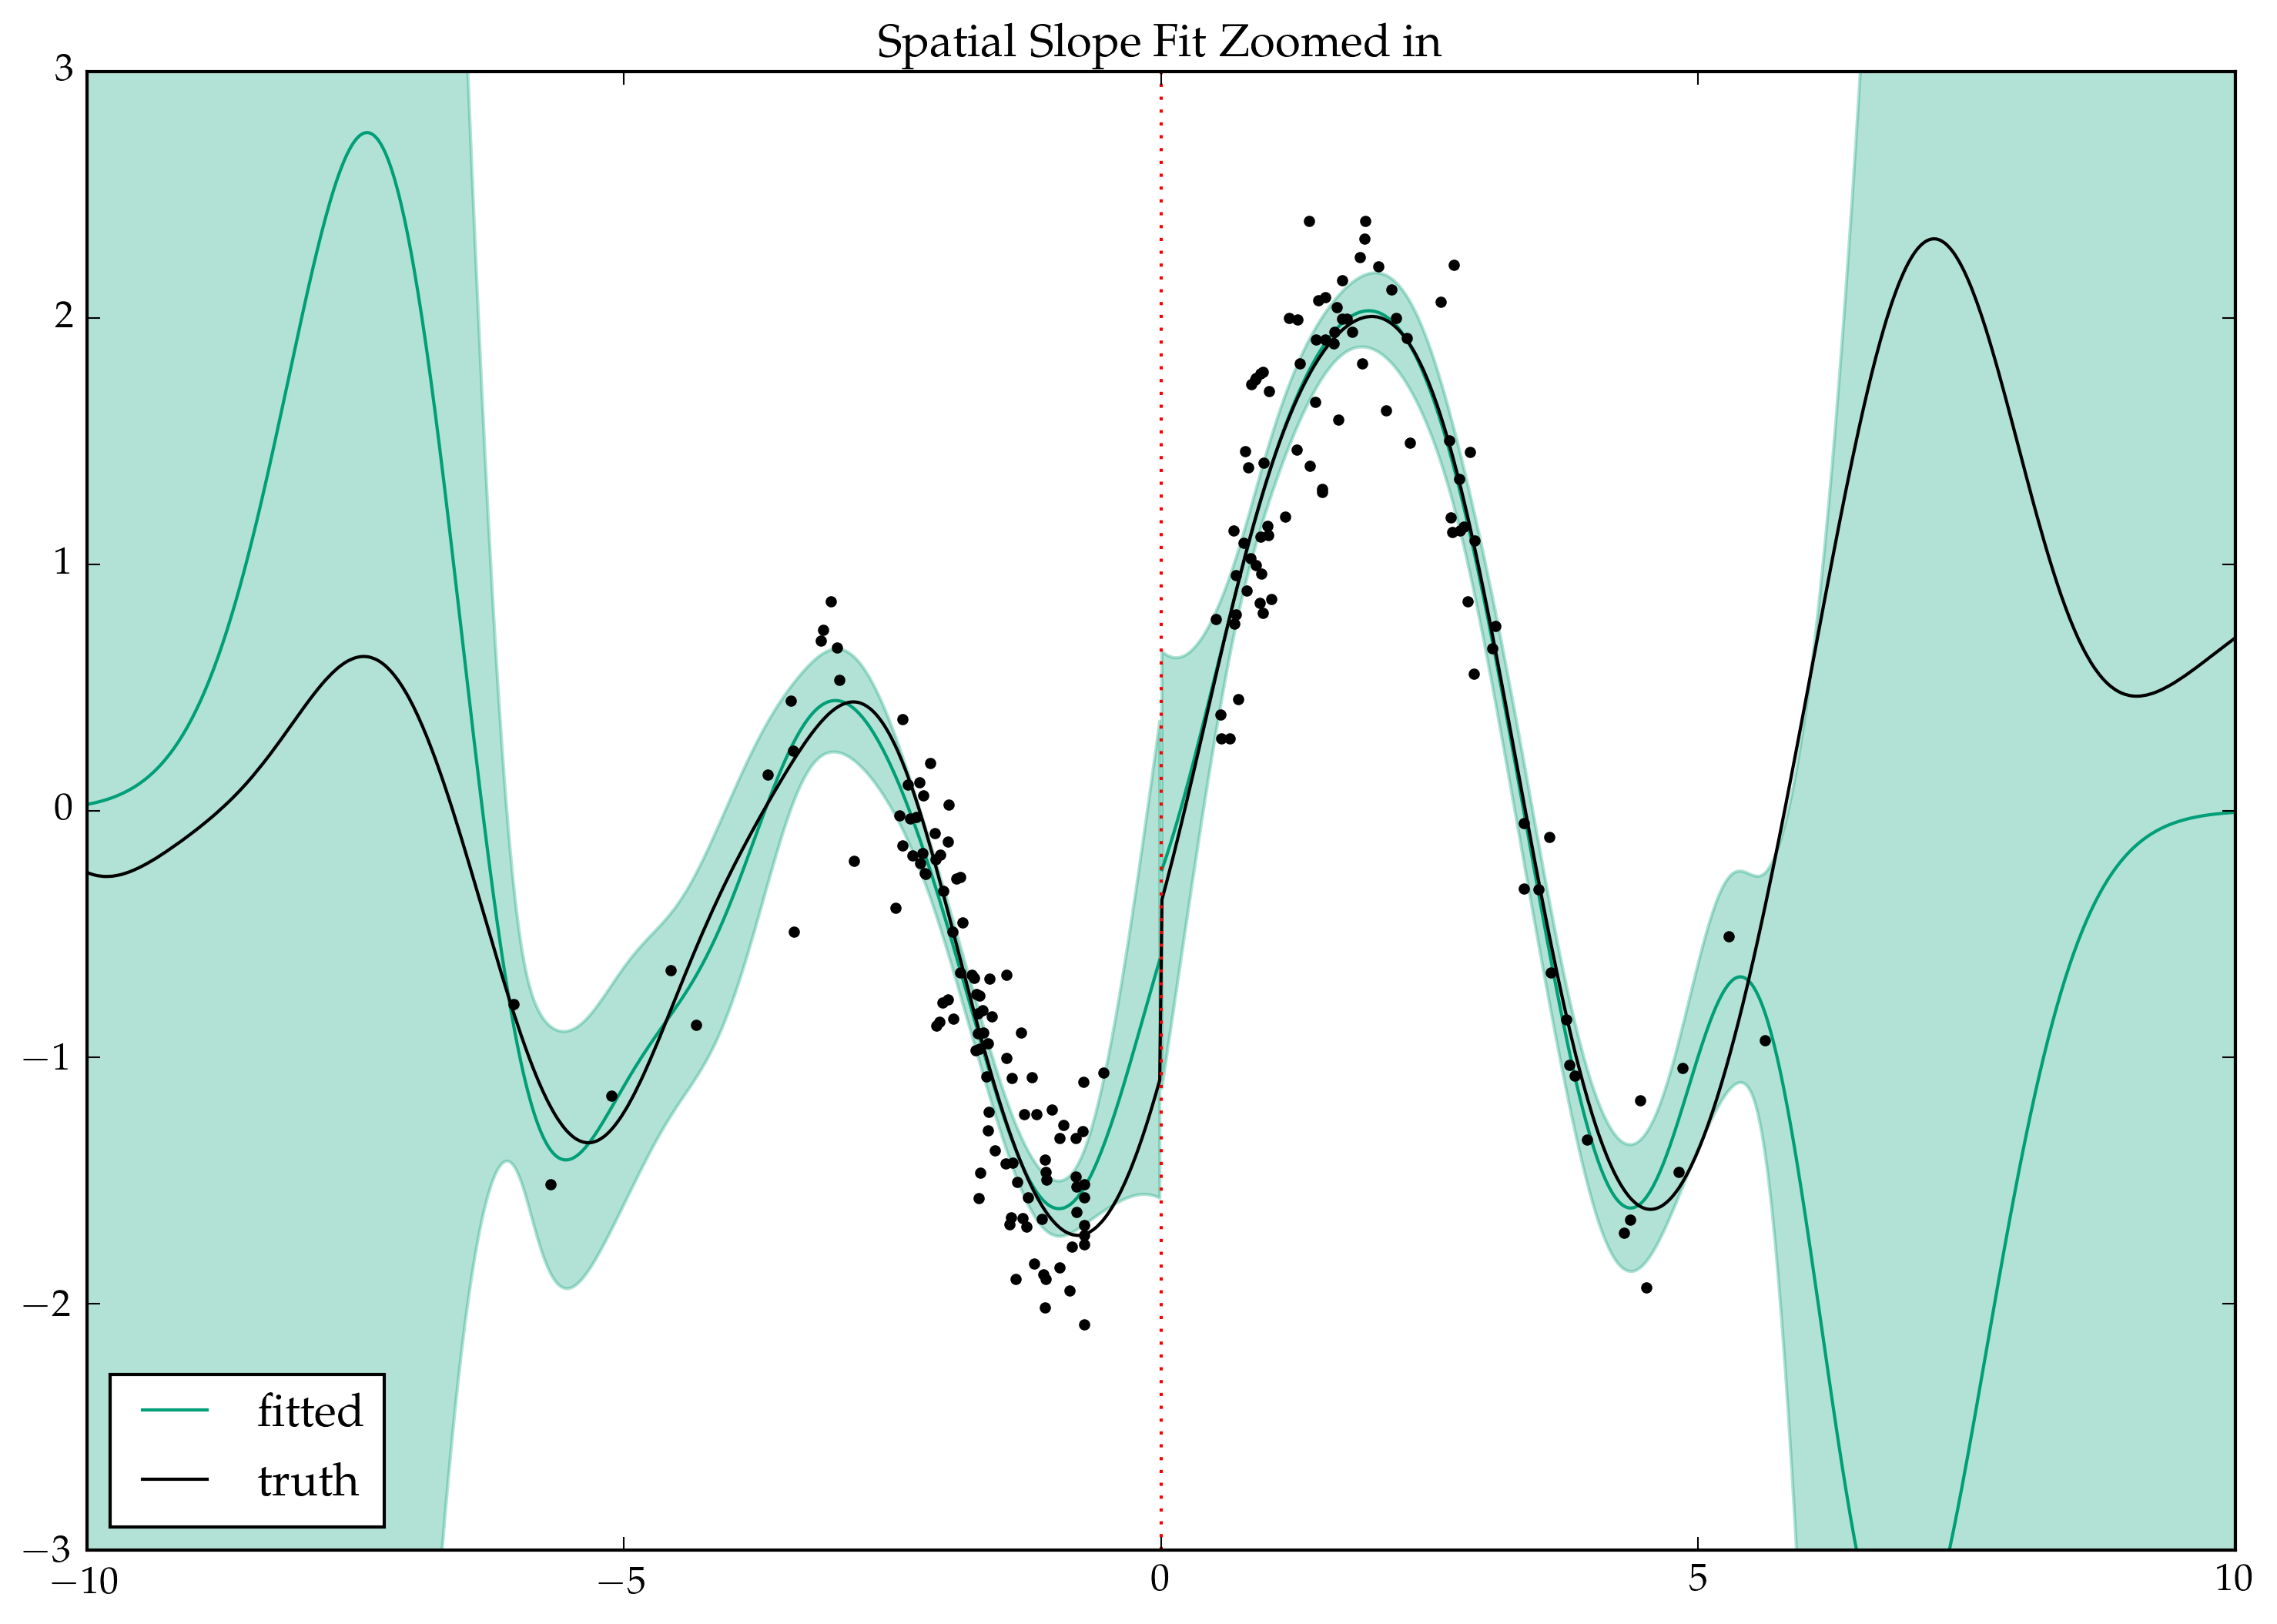

In [23]:
plot_fit(xx, lin_fit_left, lin_fit_right)
plt.title("Spatial Slope Fit Zoomed in")
plt.ylim(-3.0,3.0)
;

# Is this kernel stationary?

No, this kernel blows up away from 0

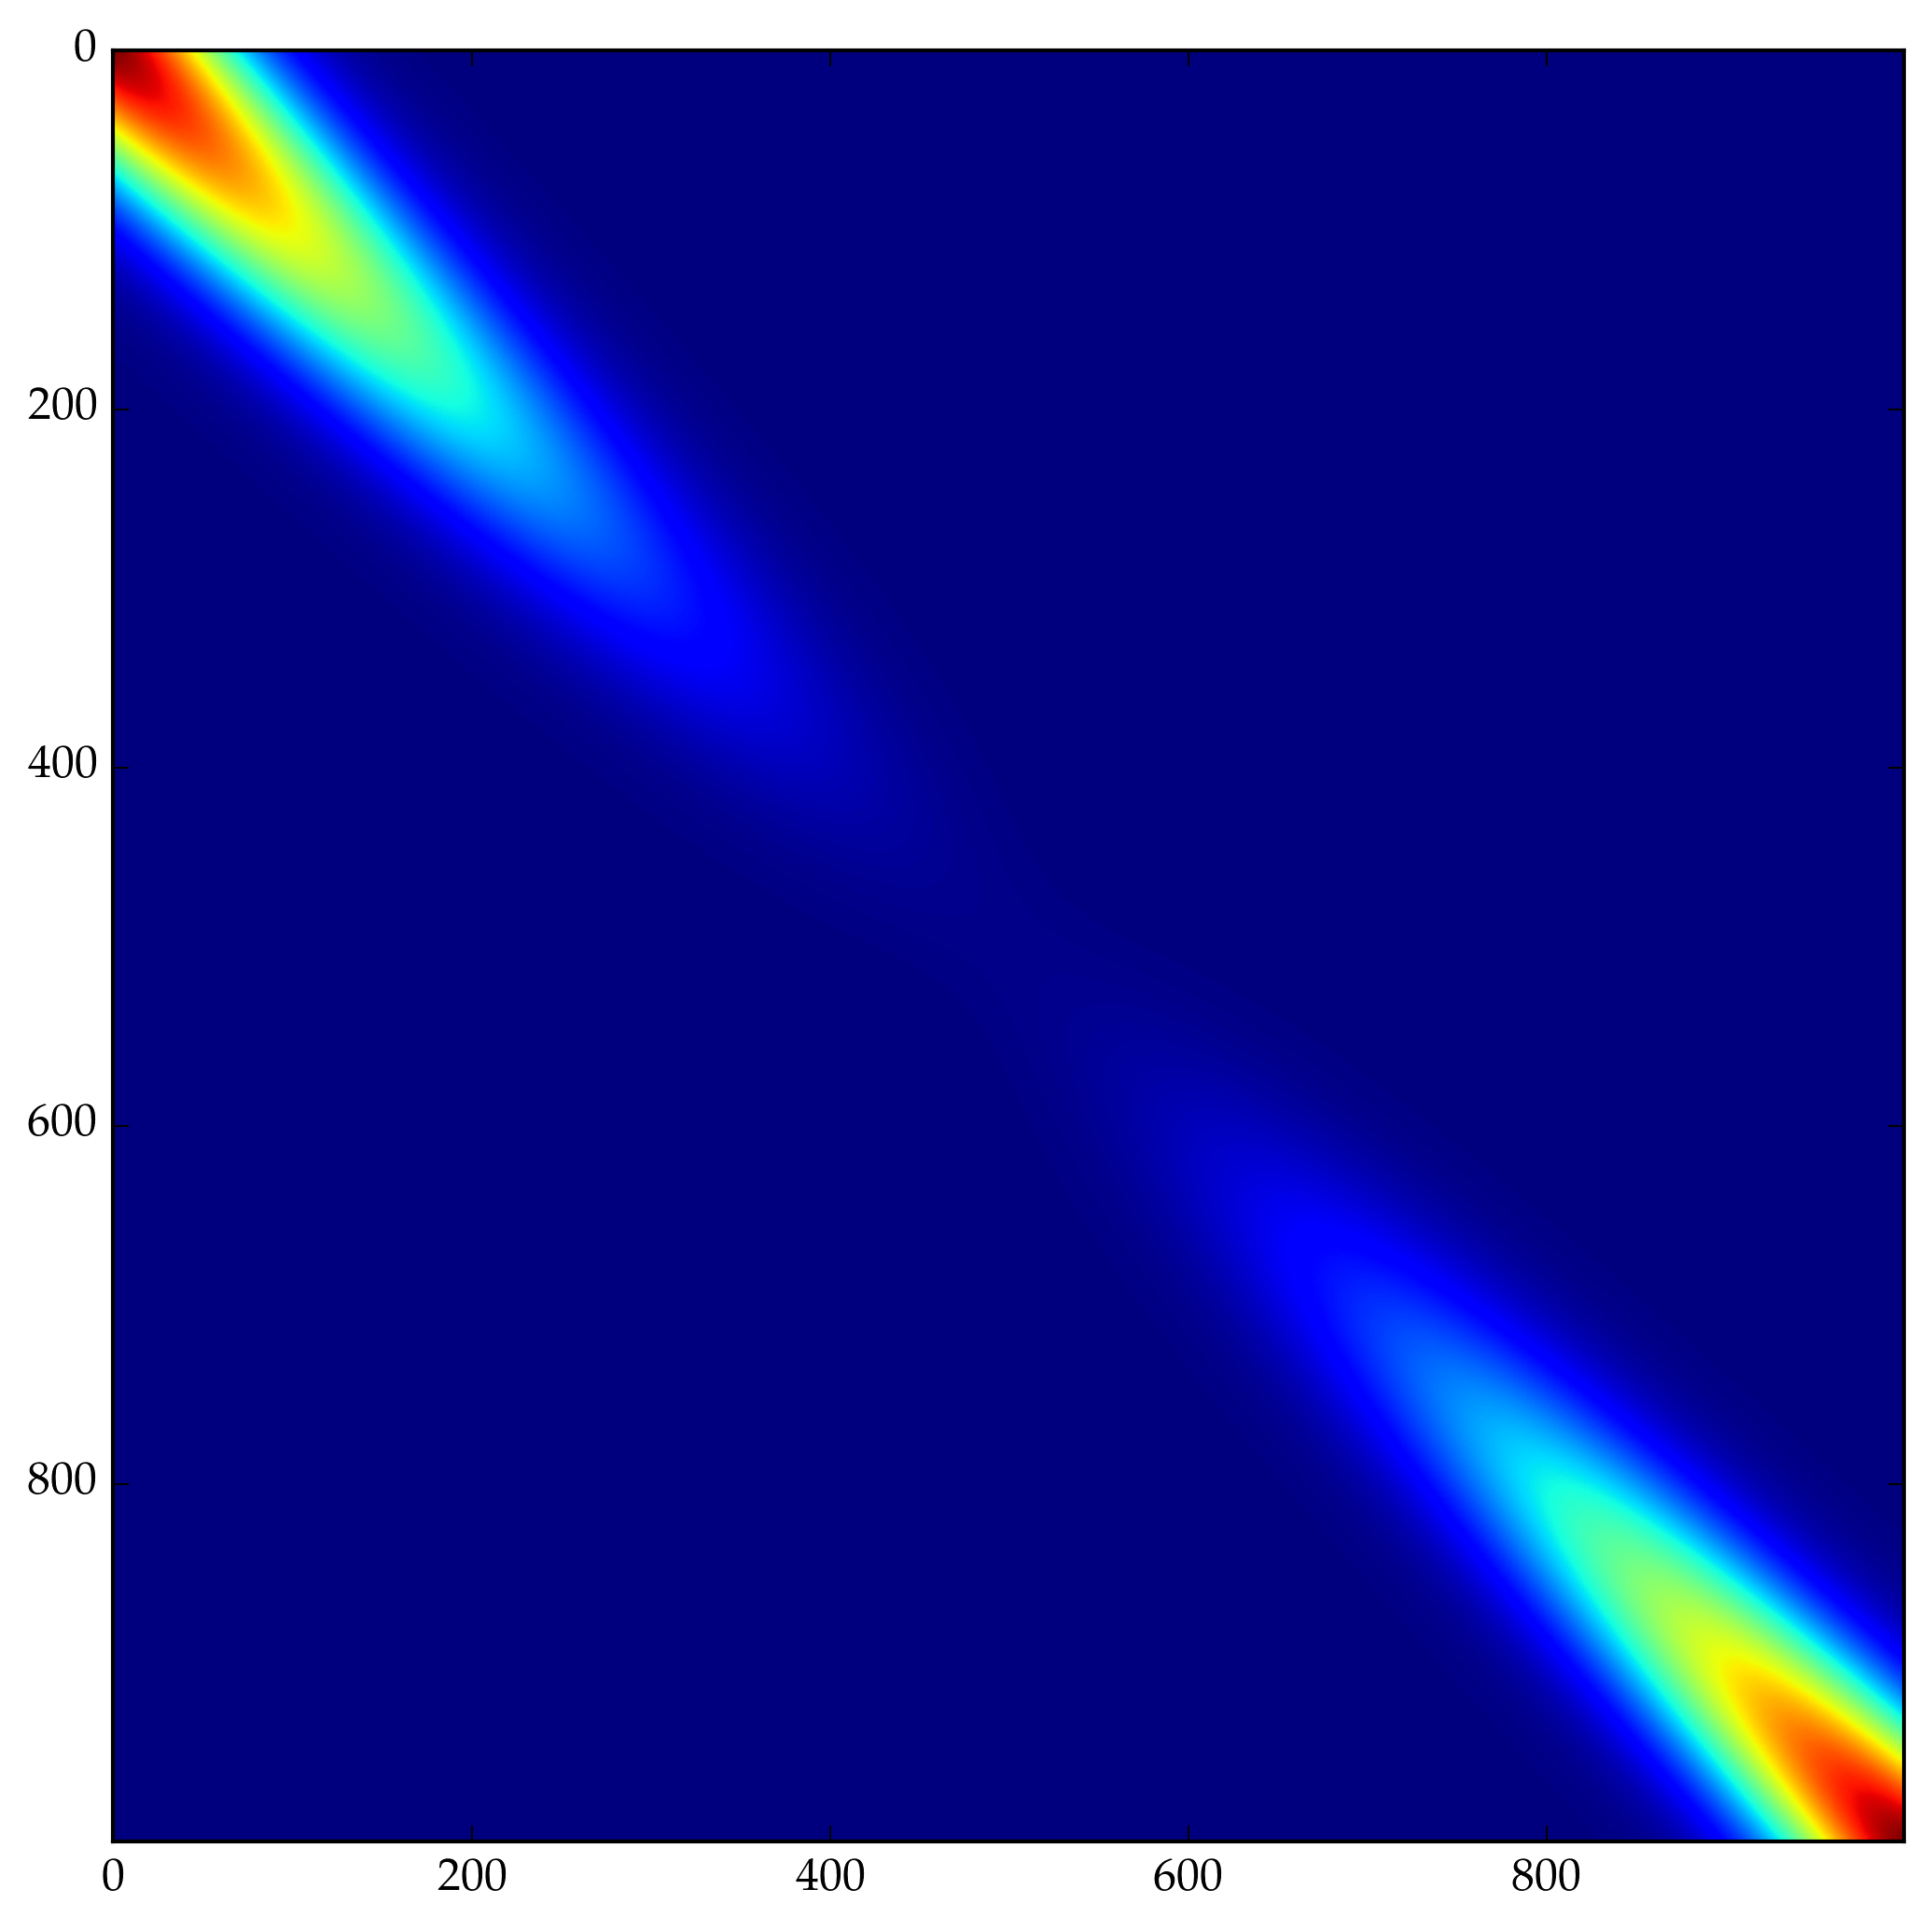

PyObject <matplotlib.image.AxesImage object at 0x31950a190>

In [25]:
plt.imshow(cov(k_spatialslope, xx'))